In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pdb
from itertools import groupby

In [2]:
# Define constants
results_folder = "Experiments/"



## SOLL
**Was muss ins Skript?**
- Box-plots der Kombinationen über die kompletten trials (1 Boxplot pro Datensatz)
- Was ist die beste Metrik-Clustering-Kombination?
	- Was ist ihr durchschnittliches Ergebnis (über alle trials)?
- Statistiken darüber was wie häufig gute ARI scores hatte?
- Statistiken darüber welche Datenblöcke/Datensätze am häufigsten Fehler verursacht haben?
	- Welche Datensätze waren besonders schwierig?
	- **Diskussion: Diese Arten von Anomalien waren besonders und wurden nicht erkannt**

## IST
 - Bester ARI score per Datensatz + Liste an settings die diesen erreicht haben
 - (Falls vorhanden) ein Setting das in allen Datensätzen den besten Score erreicht hat


In [3]:
from PIL import Image
import io
import pathlib


    

In [4]:
import json
def get_local_attributes(filepath: str) -> dict:
    # keys: "results", ["0"..."i"] = {"string", "hyper", "noise"}, "kernels", "labels", "ARI", PIC" (optional)
    with open(filepath, "r") as read_file:
        inputs = json.load(read_file)
    
    # Extract datafile, metric, clustering, segment_length and normalization from name
    # Name format: 4_Anomaly_5400_5700_300_cov_Agg_2_result.txt
    parts = filepath[:-4].split("/")[-1].split("_")
    output = inputs
    # TODO is the filepath.split correct?
    output["trial"] = filepath.split("/")[-2]
    output["datafile"] = parts[0]
    output["anomaly_range"] = parts[2:4]
    output["segment_length"] = parts[4]
    output["metric"] = parts[5]
    output["clustering"] = parts[6]
    output["normalization"] = parts[7]
    if not inputs["ARI"] == "ERROR":
        with Image.open(f'{filepath[:-5]}.png') as im:
            output["image"] = im
    return output

In [5]:

def set_axis_style(ax, labels):
    ax.xaxis.set_tick_params(direction='out')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xticks(np.arange(1, len(labels) + 1))
    ax.set_xticklabels(labels, rotation=90)
    ax.set_xlim(0.25, len(labels) + 0.75)
    ax.set_xlabel('Sample name')
    

def get_violin_plots(all_data: dict) -> dict:
    # Input: dict storing the results grouped by file (dict(filename: list( dict(), ...)))
    # Output: len(inputs) plots showing columns/rows(?) of boxplots over all possible settings
    
    # Iterate over datasets
    for dataset in range(len(all_data)):
        dataset_number = -1
        violins = list()
        # list of trials, grouped by 'important_settings'
        important_settings = ["metric", "segment_length", "clustering", "normalization"]
        data_sorted_by_trial = sorted(all_data[dataset], key=lambda e:[e[setting] for setting in important_settings])
        groups = list()
        uniquekeys = list()
        for k, g in groupby(data_sorted_by_trial, lambda e:[e[setting] for setting in important_settings]):
            group = list(g)
            groups.append(group)      # Store group iterator as a list
            uniquekeys.append(k)
            # Iterate over trials in a group to draw 1 box/violin
            ARIs = list()
            for trial in group:
                if dataset_number == -1:
                    dataset_number = trial["datafile"]
                    #segment_length = trial["segment_length"]
                ARIs.append(trial["ARI"])
            violin = {"scores": ARIs,
                     "setting": k}
            violins.append(violin)
        data_to_plot = [v["scores"] for v in violins]
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18, 4), sharey=True)

        ax.set_title(f'Dataset {dataset_number}')
        ax.set_ylabel('ARI score')
        ax.violinplot(data_to_plot)

        labels = ["_".join(v["setting"]) for v in violins]
        set_axis_style(ax, labels)
        filename = f"Violin_plot_dataset_{dataset_number}"
        plt.savefig(filename, bbox_inches='tight')

In [6]:

def set_axis_style(ax, labels):
    ax.xaxis.set_tick_params(direction='out')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xticks(np.arange(1, len(labels) + 1))
    ax.set_xticklabels(labels, rotation=90)
    ax.set_xlim(0.25, len(labels) + 0.75)
    ax.set_xlabel('Sample name')
    

def get_violin_plots_summarized(all_data: dict) -> dict:
    # Input: dict storing the results grouped by file (dict(filename: list( dict(), ...)))
    # Output: len(inputs) plots showing columns/rows(?) of boxplots over all possible settings
    
    # Iterate over datasets
    violins = list()
    for dataset in range(len(all_data)):
        dataset_number = -1
        # list of trials, grouped by 'important_settings'
        important_settings = ["metric", "segment_length", "clustering", "normalization"]
        data_sorted_by_trial = sorted(all_data[dataset], key=lambda e:[e[setting] for setting in important_settings])
        groups = list()
        uniquekeys = list()
        for k, g in groupby(data_sorted_by_trial, lambda e:[e[setting] for setting in important_settings]):
            group = list(g)
            groups.append(group)      # Store group iterator as a list
            uniquekeys.append(k)
            # Iterate over trials in a group to draw 1 box/violin
            ARIs = list()
            for trial in group:
                if dataset_number == -1:
                    dataset_number = trial["datafile"]
                    #segment_length = trial["segment_length"]
                ARIs.append(trial["ARI"])
            violin = {"scores": ARIs,
                     "setting": k}
            violins.append(violin)
    data_to_plot = [v["scores"] for v in violins]
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18, 4), sharey=True)

    ax.set_title(f'Total violin')
    ax.set_ylabel('ARI score')
    ax.violinplot(data_to_plot)

    labels = ["_".join(v["setting"]) for v in violins]
    set_axis_style(ax, labels)
    filename = f"Violin_plot_total"
    plt.savefig(filename, bbox_inches='tight')

In [7]:
def get_max_ARI(inputs : list) -> dict:
    # Iterate over the dicts inside the list
    max_score = -1
    best_settings = list()
    best_entries = list()
    for entry in inputs:
        # entry : dict (as defined in 'get_local_attributes')
        important_settings = ["metric", "segment_length", "clustering", "normalization"]
        setting = {key:entry[key] for key in important_settings}
        if type(entry["ARI"]) == str:
            pdb.set_trace()
        if entry["ARI"] > max_score:
            max_score = entry["ARI"]
            best_settings = list()
            best_settings.append(setting)
            best_entries = list()
            best_entries.append(entry)
        elif entry["ARI"] == max_score:
            best_settings.append(setting)
            best_entries.append(entry)
    result = {"score": max_score,
             "settings": best_settings, 
             "entries":best_entries}
    return result

In [8]:
from itertools import product

In [9]:
def get_global_metrics(local_metrics : list, group_by_dataset=True) -> dict:
    metrics = dict()
    # Group by file and look for highest ARI score (potentially a list)
    files = ["4", "8", "9", "22", "24", "25"]
    import pdb
    #total_list = sorted(local_metrics, key=lambda e:e["datafile"])

    # dict(filename: list(experiments))
    sorted_by_dataset = list()
    grouping_settings = ["datafile"]
    if group_by_dataset:
        data_sorted_by_groups = sorted(local_metrics, key=lambda e:[e[setting] for setting in grouping_settings])
        for k, g in groupby(data_sorted_by_groups, lambda e:[e[setting] for setting in grouping_settings]):
        #for k, g in groupby(total_list, lambda entry:entry["datafile"]):
            sorted_by_dataset.append(list(g))      # Store group iterator as a list
        best_ARIs = list()
        # Iterate over dict that groups lists by file
        for dataset in range(len(sorted_by_dataset)):
            # best_ARIs = list(dict("score", "settings", "entries"), ...)
            best_ARIs.append(get_max_ARI(sorted_by_dataset[dataset]))
        metrics["best_ARIs"] = best_ARIs
    else:
        grouping_settings = ["segment_length", "normalization", "metric", "clustering"]
        data_sorted_by_groups = sorted(local_metrics, key=lambda e:[e[setting] for setting in grouping_settings])
        for k, g in groupby(data_sorted_by_groups, lambda e:[e[setting] for setting in grouping_settings]):
        #for k, g in groupby(total_list, lambda entry:entry["datafile"]):
            sorted_by_dataset.append(list(g))      # Store group iterator as a list
        best_ARIs = list()
        # Iterate over dict that groups lists by file
        for dataset in range(len(sorted_by_dataset)):
            # best_ARIs = list(dict("score", "settings", "entries"), ...)
            best_ARIs.append(get_max_ARI(sorted_by_dataset[dataset]))
        metrics["best_ARIs"] = best_ARIs
    # Is there ANY setting that exists in ALL 'best_ARIs'?
    #if any(all(setting in compare_best_ARI for compare_best_ARI in best_ARIs) for setting in best_ARIs[0]):#
    for setting in best_ARIs[0]["settings"]:
        common_setting = setting
        for best_ARI in best_ARIs:
            if not common_setting in best_ARI["settings"]:
                 common_setting = 0
    if common_setting:
        metrics["common_best_setting"] = common_setting
    if group_by_dataset:
        plots = get_violin_plots(sorted_by_dataset)
    else:
        plots = get_violin_plots_summarized(sorted_by_dataset)
    metrics["plots"] = plots
    
    return metrics

In [10]:
#[1,2,'text'] in [[1,2,'text'], [1,2,'txt'], [1,2,'ext'], [1,2,'tet']]
[1,2,'text'] in [{"lul": [1,2,'text'], "omegalul":42, "superlul":21}, {"lul": [1,2,'tet'], "omegalul":42, "superlul":21}]
bool(0)

False

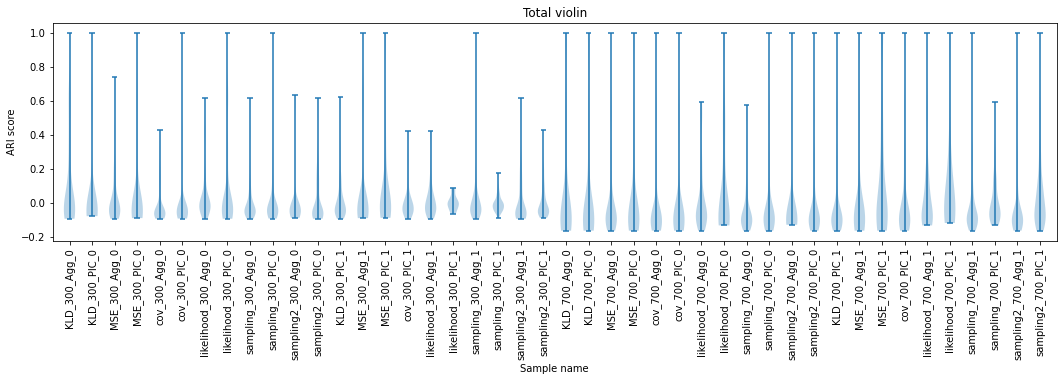

In [11]:
total_list = list()
# Iterate over folders (trials)
for subdir, dirs, files in os.walk(results_folder):
    # Iterate over files (combinations of datafile x metric x clustering x segment_length x normalization)
    for file in files:
        if file.endswith(".json"):
            total_list.append(get_local_attributes(os.path.join(subdir, file)))
final_result = get_global_metrics(total_list, group_by_dataset=False)

In [12]:
final_result.keys()
final_result['best_ARIs']

[{'score': 1.0,
  'settings': [{'metric': 'KLD',
    'segment_length': '300',
    'clustering': 'Agg',
    'normalization': '0'},
   {'metric': 'KLD',
    'segment_length': '300',
    'clustering': 'Agg',
    'normalization': '0'},
   {'metric': 'KLD',
    'segment_length': '300',
    'clustering': 'Agg',
    'normalization': '0'},
   {'metric': 'KLD',
    'segment_length': '300',
    'clustering': 'Agg',
    'normalization': '0'}],
  'entries': [{'results': [[-0.0,
      486.07,
      23.49,
      99.81,
      152.63,
      326.86,
      7.91,
      27.66,
      194.98,
      309.51,
      157.17,
      528.77,
      443.87,
      86.68,
      299.71,
      6.21,
      3.45,
      430.47,
      3797.28,
      20.19,
      27.98,
      109.74,
      118.13,
      98.05,
      41.49,
      53.22,
      159.79],
     [486.07,
      0.0,
      590.72,
      531.26,
      567.63,
      853.27,
      431.57,
      464.66,
      604.22,
      789.02,
      718.43,
      874.57,
      41.14,
